In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import glob, os
import operator
from heapq import nlargest
sns.set_style('darkgrid')
%matplotlib inline

# LEAGUE OF LEGEND RANKED MATCH

* Can ranked matchmaking be assumed to be unbiased (or adjusted for red-side advantage)?
* Can early lead (kills and tower) lead to late game objective gain?


## Reading CSV and Cleaning up Dataset

In [2]:
stats1_df = pd.read_csv('dataset/stats1.csv')

In [3]:
champions_df = pd.read_csv('dataset/champs.csv')

In [4]:
matches_df = pd.read_csv('dataset/matches.csv')

In [5]:
players_df = pd.read_csv('dataset/participants.csv')

In [6]:
bans_df = pd.read_csv('dataset/teambans.csv')

In [7]:
team_stats_df = pd.read_csv('dataset/teamstats.csv')

### Dropping unncessary/unknown data

In [8]:
stats = stats1_df.drop(['item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'trinket'], 1)
matches = matches_df.drop(['queueid', 'creation'], 1)
players = players_df.drop(['ss1', 'ss2'], 1)
bans = bans_df
team_stats = team_stats_df
champions = champions_df
df=pd.DataFrame

### Further cleaning data and replacing id columns with corresponding names of Team Side and Win Condition


In [9]:
matches = matches.rename(columns = {'platformid': 'region'})

In [10]:
# Function that will assign team color for red or blue
# Function is no long neccesary bc with scaling dataset, it will slow down significantly due to append method.

def assign_team_color(side):
    
    '''This to create an array and append new Value to an existing colm and replace existing column with it'''
    
    sideColor = np.array([])
    for team in side:
        if int(team) == 100:
            sideColor = np.append(sideColor, "Blue")
        elif int(team) == 200:
            sideColor = np.append(sideColor, "Red")
        else:
            sideColor = np.append(sideColor, "Nan")
    new_color_df = pd.DataFrame(sideColor)
    return new_color_df

In [11]:
#Using replace method instead appending to new array save alot of time and memory.

bans['teamid'] = bans['teamid'].replace([100], 'Blue').replace([200], 'Red')
team_stats['teamid'] = team_stats['teamid'].replace([100], 'Blue').replace([200], 'Red')
players['role'] = players['role'].replace(['DUO_CARRY'], 'ADC').replace(['DUO_SUPPORT'], 'SUPPORT')
stats['win'] = stats['win'].replace([0], 'Defeat').replace([1], 'Victory')
players.loc[players.role == 'ADC', 'position'] = 'ADC'
players.loc[players.role == 'SUPPORT', 'position'] = 'SUPPORT'
players['position'] = players['position'].replace(['BOT'], 'UNKNOWN')

In [12]:
bans.head()

,matchid,teamid,championid,banturn
0,10,Blue,11,1
1,10,Blue,117,3
2,10,Blue,120,5
3,10,Red,84,2
4,10,Red,201,4


### Replacing Champions ID with Champion Names

In [13]:
champions.set_index(['id'], inplace=True)
champions.head()

,name
id,
24,Jax
37,Sona
18,Tristana
110,Varus
114,Fiora


In [14]:
champCols = ['championid']

In [15]:
def idToName(ID, championInfo):
    '''This Funciton is to translate (convert) champion
    ID to champion name in bans/players dataset columns'''
    
    champ = championInfo['name'][ID]
    return champ
    

In [16]:
#Looping through 'championid' columns inside players and bans to replace id with name

for c in champCols:
    bans[c] = bans[c].apply(lambda x: idToName(x, champions)) 
    players[c] = players[c].apply(lambda x: idToName(x, champions))


In [17]:
bans.head()

,matchid,teamid,championid,banturn
0,10,Blue,Master Yi,1
1,10,Blue,Lulu,3
2,10,Blue,Hecarim,5
3,10,Red,Akali,2
4,10,Red,Braum,4


In [18]:
stats.head()

,id,win,kills,deaths,assists,largestkillingspree,largestmultikill,killingsprees,longesttimespentliving,doublekills,...,neutralminionskilled,ownjunglekills,enemyjunglekills,totcctimedealt,champlvl,pinksbought,wardsbought,wardsplaced,wardskilled,firstblood
0,9,Defeat,6,10,1,2,2,2,643,2,...,69,42,27,610,13,0,0,10,0,0
1,10,Defeat,0,2,12,0,0,0,1116,0,...,1,1,0,211,14,1,0,17,3,0
2,11,Defeat,7,8,5,5,2,1,584,2,...,3,1,2,182,14,1,0,13,5,0
3,12,Defeat,5,11,2,2,1,1,300,0,...,6,6,0,106,15,0,0,3,0,0
4,13,Defeat,2,8,2,0,1,0,504,0,...,4,3,1,159,15,0,0,10,0,0


### Sorting clean data and then plotting some visual to pick/bans and team stats.

In [19]:
sortedChampPick = sorted(players['championid'])
sortedChampBan = sorted(bans['championid'])

In [20]:
# Getting top 10 most freq picked champions
pick_df = df(players['championid'])
# pick_df.describe()
pick_counts = players['championid'].value_counts(ascending=True).to_dict()
sorting_dict = sorted(pick_counts.items(), key=operator.itemgetter(1))
top_10_freq = nlargest(10, pick_counts, key=pick_counts.get)
top_10_freq

['Lee Sin',
 'Caitlyn',
 'Lucian',
 'Thresh',
 'Ahri',
 'Vayne',
 'Yasuo',
 'Xayah',
 'Orianna',
 'Ezreal']

In [21]:
#Getting top 10 most banned champion
ban_df = df(sortedChampBan)
# ban_df.describe()
ban_counts = bans['championid'].value_counts(ascending=True).to_dict()
sorting_dict = sorted(ban_counts.items(), key=operator.itemgetter(1))
top_10_ban = nlargest(10, ban_counts, key=ban_counts.get)
top_10_ban

['Yasuo',
 'Fizz',
 'Xayah',
 'Lulu',
 'Darius',
 'Sejuani',
 'Zed',
 'Katarina',
 'Fiora',
 'Ivern']

#### Visualization for champion picked and bans

Text(0.5,1,'Champion Banned')

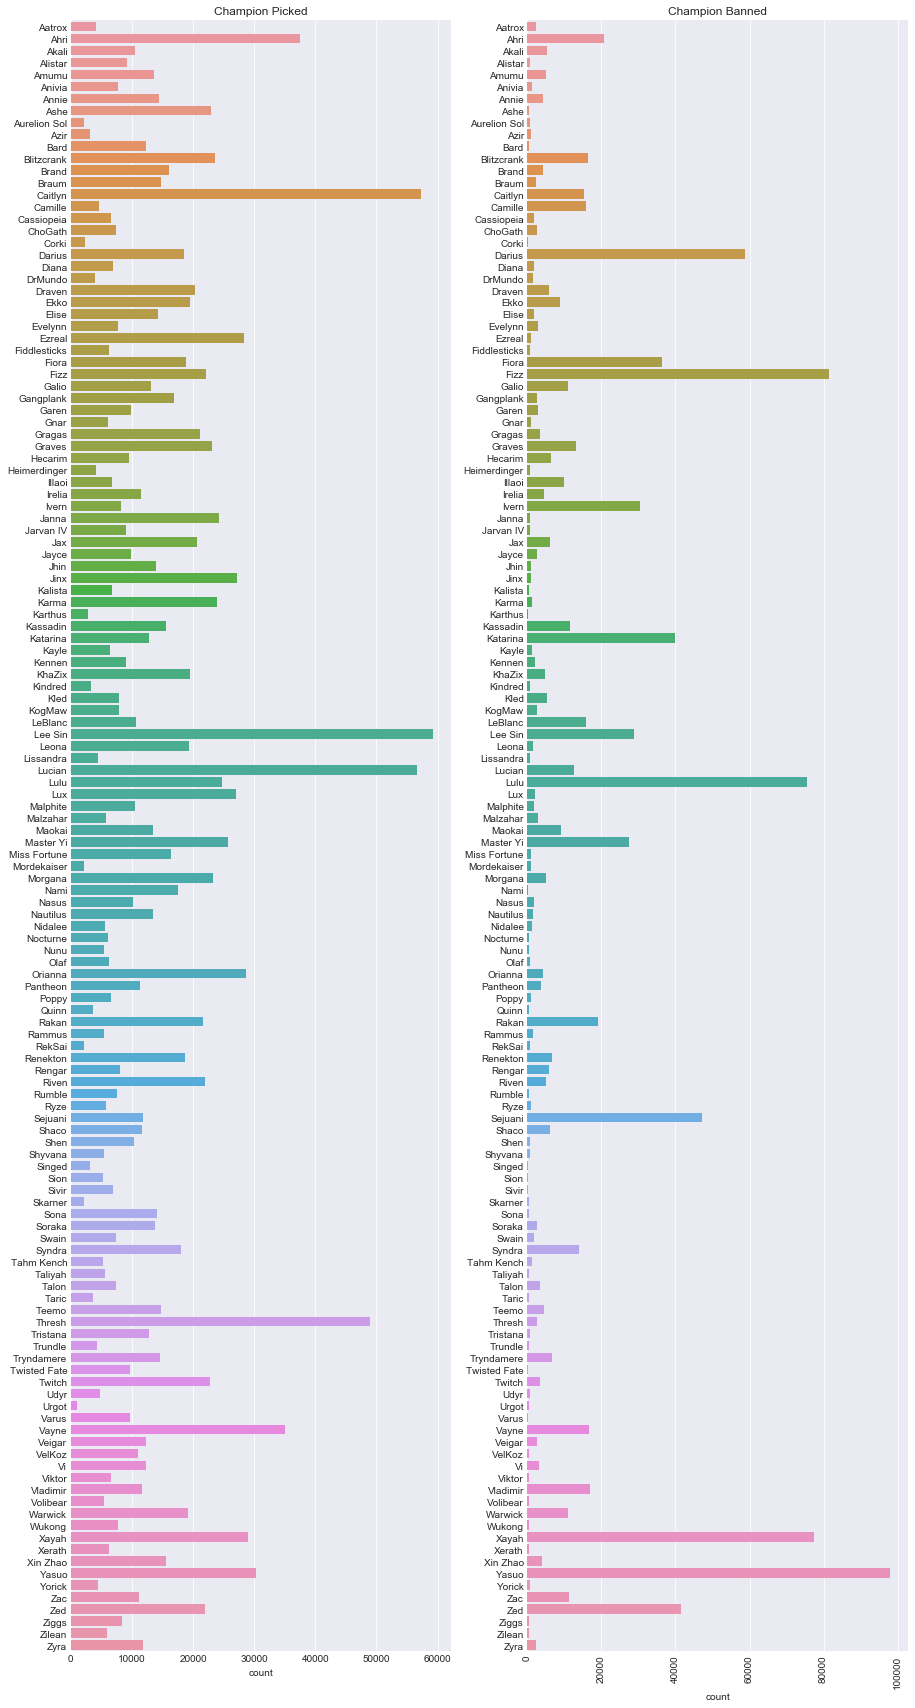

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,30))
plt.xticks(rotation=90)
sns.countplot(y=sortedChampPick, data=bans, ax=ax1)
sns.countplot(y=sortedChampBan, data=players, ax=ax2)
ax1.set_title('Champion Picked')
ax2.set_title('Champion Banned')


#### Points to make about this graph

1. Top ban champions are consistently mostly assassin and bruisers.

2. Suprisingly, Lulu, and Xayah are on the top list. This can indicate that Xayah top ban was due to her recent released and the nerf hammer had not hit her.

3. Top picked are mostly ADC.

4. Yasuo is both most banned and picked. Whats wrong with these people, yasuo is dank af. 

In [23]:
matches_not_eu = matches[(matches['region'] != 'EUW1')]

### Finding freq of position of rank matches

In [24]:
role_total = players[['position']].apply(pd.value_counts)
role_total['count'] = role_total[['position']].sum(axis=1)
role_total

,position,count
JUNGLE,373313,373313
MID,363367,363367
TOP,362233,362233
SUPPORT,339072,339072
ADC,339071,339071
UNKNOWN,57464,57464


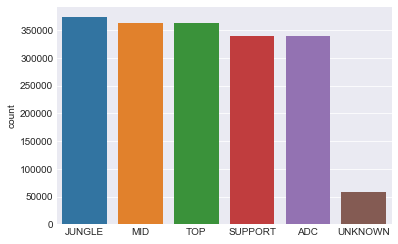

In [25]:
sns.barplot(x=role_total.index,y=role_total['count'])

### Finding Freq of first Objective for both side of the map red vs blue

In [26]:
blue_team_first_blood = team_stats[(team_stats['teamid'] == 'Blue') & (team_stats['firstblood'] == 1)]
red_team_first_blood = team_stats[(team_stats['teamid'] == 'Red') & (team_stats['firstblood'] == 1)]

In [27]:
red_fb_count = red_team_first_blood.firstblood.count()
blue_fb_count = blue_team_first_blood.firstblood.count()

In [28]:
# Replacing 'first' column with name indicating red or blue team got it first.

team_col = ['firstblood', 'firsttower', 'firstinhib', 'firstbaron', 'firstdragon', 'firstharry']
team_stats[(team_stats['teamid'] == 'Blue')] = team_stats[team_col].replace([0], 'Red').replace([1], 'Blue')
team_stats[(team_stats['teamid'] == 'Red')] = team_stats[team_col].replace([0], 'Blue').replace([1], 'Red')

In [29]:
#Counting number of first total of team red and blue
team_first = team_stats[['firstblood', 'firsttower', 'firstinhib', 'firstbaron', 'firstdragon', 'firstharry']]
firstTotal = team_first.apply(pd.value_counts)

In [31]:
firstTotal

,firstblood,firsttower,firstinhib,firstbaron,firstdragon,firstharry
Blue,188731,189847,189280,179133,183785,187102
Red,179407,178291,178858,189005,184353,181036


#### Visualization of first objective comparison for both team

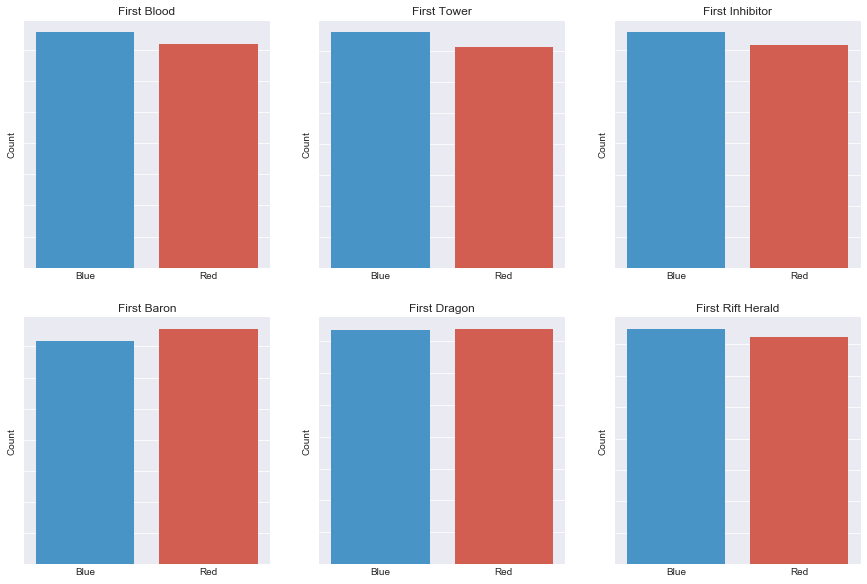

In [30]:
#using bar graph to plot freq of first for both team

plotColors = ['#3498DB','#E74C3C','#BDC3C7']
firstLabels = ['First Blood','First Tower', 'First Inhibitor', 'First Baron', 'First Dragon', 'First Rift Herald']
nrows, ncols = 2,3
fig = plt.figure(figsize=(15,10))
for i in range(1,7):
    ax = fig.add_subplot(nrows,ncols,i)
    sns.barplot(x=firstTotal.index,y=firstTotal[firstTotal.columns[i-1]],palette=plotColors)
    ax.set_ylabel('Count')
    ax.yaxis.set_ticklabels([])
    ax.set_title(firstLabels[i-1])

#### Points interesting about this graph

##### QUESTION: Can ranked matchmaking be assumed to be unbiased (or adjusted for red-side advantage)?

1. In a large dataset, plots are mostly even.

2. Suprising to see that red team have more control over baron. One would assume it would be easier for blue to do baron first due to the the position of baron pit's door is facing blue side. However, it could be the fact that it is closer to red side or even the position of baron pit make it easier to steal.

3. First blood and tower leans toward blue side. Not really sure why this is a cause because both side should be able to have an equal chance of getting first blood. One assumption could be that jungler tend to gank top alot more during early game. Red Team top side have more vunerability of getting kill by jungler because of tri-bush. Harder to gank bottom side via tri-bush than top side.

4. The last 2 plot of first herald and first dragon are not suprising. Red side should have advantage over dragon early while herald is favour more for blue due to pit positions. 